## Imports

In [2]:
import numpy as np
import numpyro
from numpyro import distributions as dist
from numpyro.infer import MCMC, HMC, Predictive
from numpyro.infer.initialization import init_to_value

import jax
from jax import random, vmap
import jax.numpy as jnp
from jax.nn import relu

display(jax.devices())

import pickle

from src.models.NumPyroModels import NumPyroModel
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.data_utils import *
from src.utils.numpyro_utils import *


%load_ext autoreload
%autoreload 2

%matplotlib inline

/home/codygrogan/PythonProjects/Uncertainty_Quantification/venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[cuda(id=0)]

## Creating Data Set

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:88: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


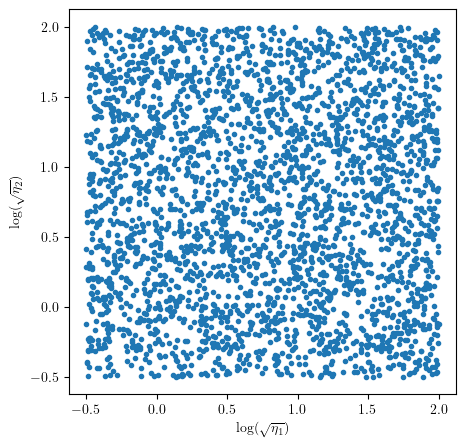

In [3]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 3_000, shuffle=True, gen_type="All")

etas_test, gs_test = generate_log_data(SSG_gen, log, 600, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)

## Scaling Data and Converting

In [4]:
x_scaler = CustomScalerX().fit(etas_train)
y_scaler = CustomScalerY().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_scaled_test = x_scaler.transform(etas_test)
y_scaled_test = y_scaler.transform(gs_test)

x_train = jnp.array(x_scaled_train, dtype=jnp.float32)
y_train = jnp.array(y_scaled_train, dtype=jnp.float32)

## Network and HMC parameters

In [5]:
hmc_checkpoints = "Model_Checkpoints/HMC/"

#gold_step_size = 55e-5
#gold_trajectory_length = 1.6501

step_size = 50e-5
trajectory_length = 2.501
num_steps = int(np.ceil(trajectory_length // step_size))
print("Number of Steps: ", num_steps)

init_dict = pickle.load(open(hmc_checkpoints+"HMC_Initialize_large.pkl", "rb"))

for key, value in init_dict.items():
    print(key)
    init_dict[key] = jnp.array(value.T)
    print(init_dict[key].shape)

net_params = {
    "input_dim": 2,
    "output_dim": 3,
    "hidden_dim": 20,
    "num_layers": 4,
    "data_size": len(x_train),
    "layer_prior_scale": 5.0,
}

hmc_params = {
    "model": NumPyroModel(**net_params),
    "step_size": step_size,
    "trajectory_length": trajectory_length,
    "adapt_step_size": False,
    "dense_mass": True,
    "init_strategy": init_to_value(values=init_dict),
}

mcmc_params = {
    "num_warmup": 4,
    "num_samples": 1,
    "num_chains": 1
}



Number of Steps:  5001
w1
(2, 20)
b1
(20,)
w2
(20, 20)
b2
(20,)
w3
(20, 20)
b3
(20,)
w4
(20, 3)
b4
(3,)


## Run Training

In [7]:
print(hmc_params["model"])

kernel = HMC(**hmc_params)

mcmc = MCMC(kernel, **mcmc_params)

rng_key = random.PRNGKey(0)

mcmc.run(rng_key, x_train, y_train)

Layer 1: 2 -> 20
Layer 2: 20 -> 20
Layer 3: 20 -> 20
Layer 4: 20 -> 3



sample: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it, 5002 steps of size 5.00e-04. acc. prob=0.00]


## Saving MCMC Run

In [56]:
save_prefix = f"HMC_{mcmc_params['num_warmup']}_{mcmc_params['num_samples']}_{num_steps}"

save_numpyro_mcmc(mcmc, hmc_checkpoints, save_prefix)

In [7]:
saves = "Model_Checkpoints/HMC/HMC_20_20_2500"
num_samples = 3
samples = []
for i in range(num_samples):
    sample = pickle.load(open(saves+f"_samples_{i}.pickle", "rb"))
    samples.append(sample)

samples_dict = {}

for i in range(num_samples):
    for key, value in samples[i].items():
        if key in samples_dict:
            samples_dict[key] = jnp.concatenate((samples_dict[key], value))
        else:
            samples_dict[key] = value

for key, value in samples_dict.items():
    print(key, value.shape)

import matplotlib.pyplot as plt

params = samples['w1']

ind1 = 4
ind2 = 1
for i in range(1):
    plt.plot(params[i, :, ind1, ind2].cpu().numpy(), label=f"Weight: [{ind1},{ind2}]---Chain {i}")

plt.legend()
plt.show()

b1 (40, 20)
b2 (40, 20)
b3 (40, 20)
b4 (40, 3)
w1 (40, 2, 20)
w2 (40, 20, 20)
w3 (40, 20, 20)
w4 (40, 20, 3)


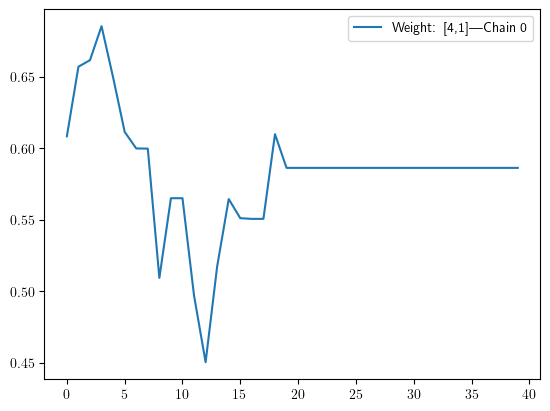